# Statistics
Let's take a look at some statistics of the data we have.

In [1]:
from collections import defaultdict

import matplotlib.pyplot as plt
import torch

from src.data.data_loading import BaseballData
from src.model.at_bat import PitchResult
from src.model.pitch_type import PitchType
from src.model.zones import ZONES_DIMENSION

bd = BaseballData.load_with_cache()

Loading baseball data... done


In [5]:
pitch_types = torch.zeros(len(PitchType))
pitch_type_locations = defaultdict(lambda: torch.zeros(ZONES_DIMENSION, ZONES_DIMENSION))
pitch_result_locations = defaultdict(lambda: torch.zeros(ZONES_DIMENSION, ZONES_DIMENSION))
pitch_results = torch.zeros(len(PitchResult))
expected_strikes = torch.zeros(ZONES_DIMENSION, ZONES_DIMENSION)

for pitch in bd.pitches:
    for x, y in pitch.location.coords:
        pitch_type_locations[pitch.type.value][x, y] += 1
        pitch_result_locations[pitch.result.value][x, y] += 1
    pitch_types[pitch.type.value] += 1
    pitch_results[pitch.result.value] += 1
    if pitch.at_bat_state.strikes == 0 and pitch.at_bat_state.balls == 3:
        for x, y in pitch.location.coords:
            expected_strikes[x, y] += 1

In [ ]:
for pt, locs in pitch_type_locations.items():
    plt.figure()
    plt.imshow(locs, cmap='gray')
    plt.title(f'Pitch Locations for {PitchType(pt).name}')
for pr, locs in pitch_result_locations.items():
    plt.figure()
    plt.imshow(locs, cmap='gray')
    plt.title(f'Pitch Locations for {PitchResult(pr).name}')

In [ ]:
plt.bar([pr.name for pr in PitchResult], pitch_results)
plt.title('Pitch Results')

In [ ]:
plt.bar([pt.name for pt in PitchType], pitch_types)
plt.title('Pitch Types')

Text(0.5, 1.0, 'Pitches on 3-0 Count')

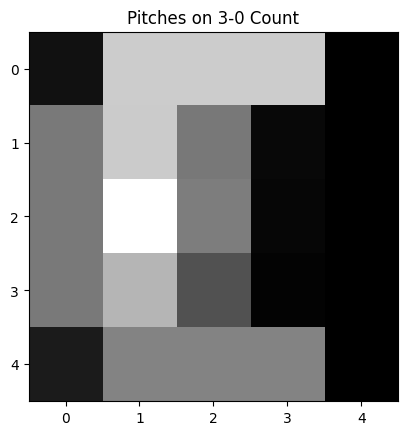

In [6]:
plt.imshow(expected_strikes, cmap='gray')
plt.title('Pitches on 3-0 Count')

# Exploring the Learned Swing Result Distribution
Let's examine the network's performance across different conditions, with known
meaningful differences.

In [2]:
from src.data.datasets import SwingResult
from typing import Callable
from src.model.pitch import Pitch
from src.data.datasets import PitchSwingDataset

test_data = PitchSwingDataset.get_random_split(bd, 0.2, seed=80)[1].pitches

conditions: dict[str, Callable[[Pitch], bool]] = {
    'all': (lambda p: True),
    '30': (lambda p: p.at_bat_state.balls == 3 and p.at_bat_state.strikes == 0),
    '02': (lambda p: p.at_bat_state.balls == 0 and p.at_bat_state.strikes == 2),
    'ball': (lambda p: not p.location.is_strike),
    'strike': (lambda p: p.location.is_strike),
}

matching_pitches = defaultdict(list)

actual_distribution = defaultdict(lambda: torch.zeros(len(SwingResult)))

for i in range(len(test_data)):
    for name, condition in conditions.items():
        pitch = test_data[i]
        if condition(pitch):
            matching_pitches[name].append(pitch)
            actual_distribution[name][SwingResult.from_pitch_result(pitch.result)] += 1

In [58]:
from torch.utils.data import DataLoader
from src.distributions.swing_outcome import SwingOutcome

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = SwingOutcome().to(device)
path = '../../model_weights/swing_outcome, g=2.75.pth'
model.load_state_dict(torch.load(path))

predicted_distribution = defaultdict(lambda: torch.zeros(len(SwingResult)).to(device))

for condition_name, pitches in matching_pitches.items():
    dataset = PitchSwingDataset(bd, None, pitches=pitches)
    dataloader = DataLoader(dataset, batch_size=512)
    for pitch, result in dataloader:
        pitcher, batter, pitch, strikes, balls = [t.to(device) for t in pitch]
        predicted_distribution[condition_name] += model(pitcher, batter, pitch, strikes, balls).sum(dim=0)

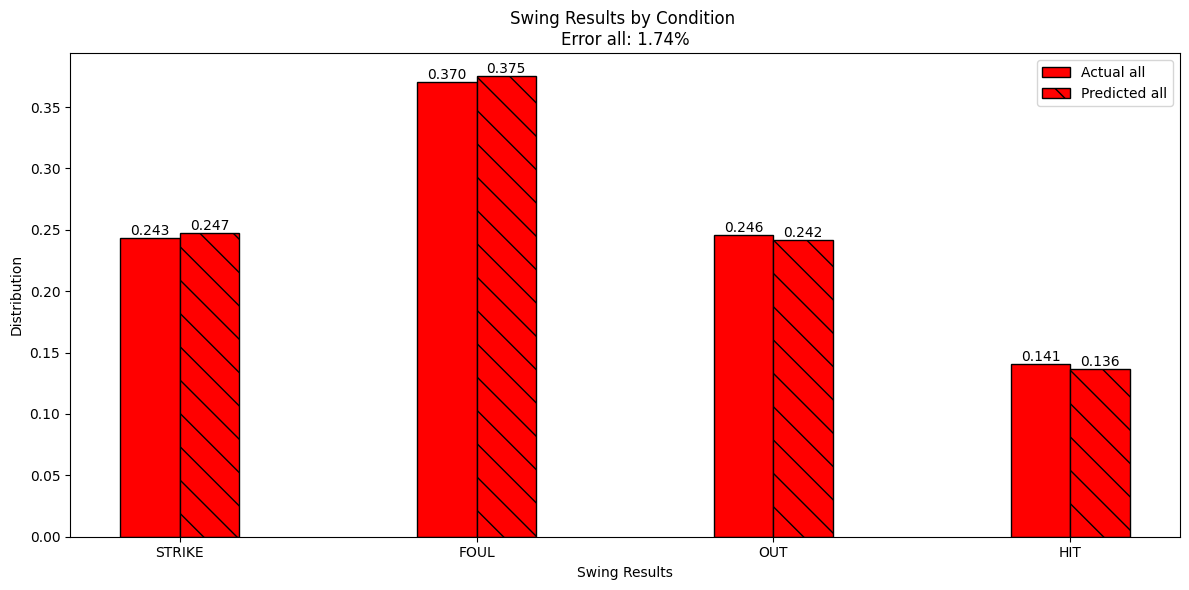

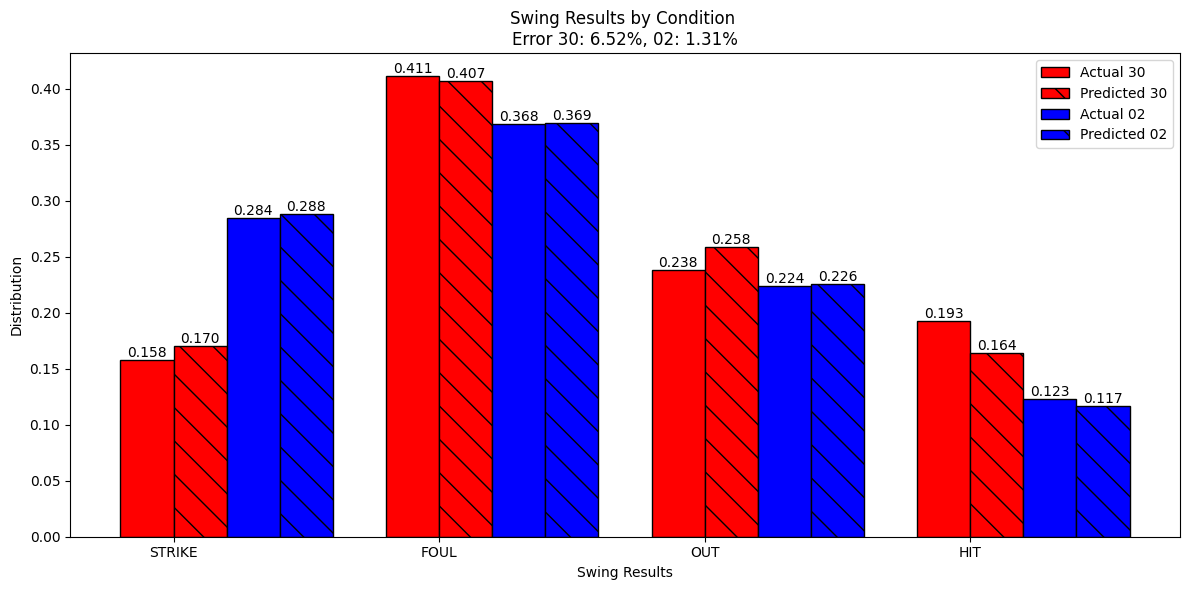

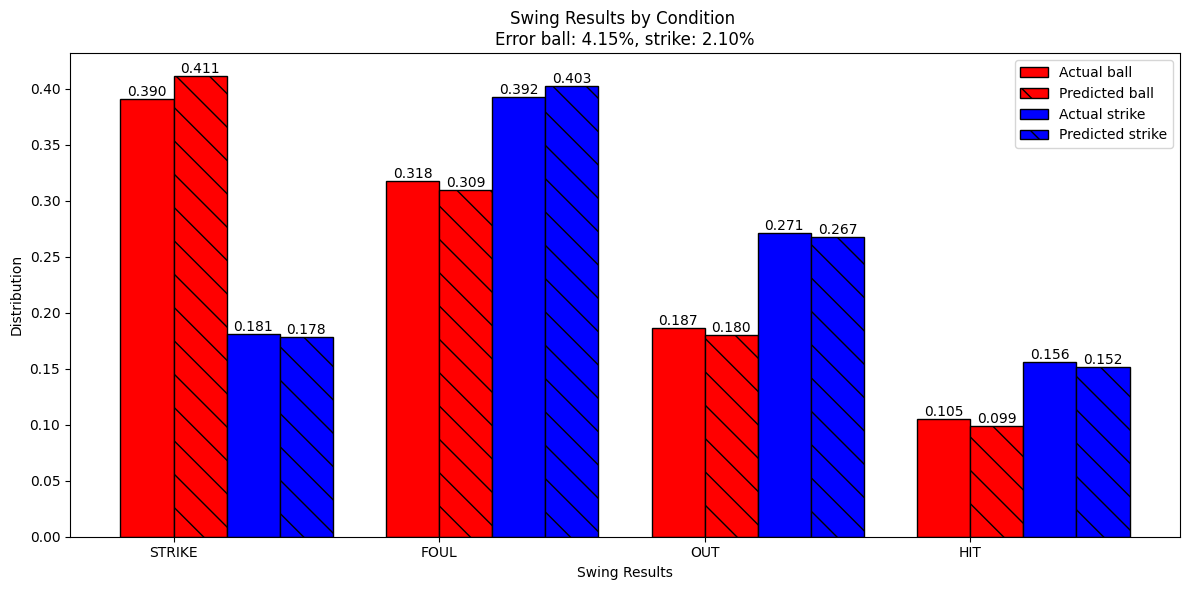

In [59]:
import numpy as np


def get_distribution(distribution: dict[str, torch.Tensor], c_name: str):
    return distribution[c_name].cpu().detach().numpy() / len(matching_pitches[c_name])

def compare_conditions(condition1: str, condition2: str = None):
    swing_results = [sr.name for sr in SwingResult]
    x = np.arange(len(swing_results))  # the label locations
    width = 0.2  # the width of the bars

    fig, ax = plt.subplots(figsize=(12, 6))

    actual_distribution_c1 = get_distribution(actual_distribution, condition1)
    predicted_distribution_c1 = get_distribution(predicted_distribution, condition1)
    
    # Plot for condition1
    bars_actual_c1 = ax.bar(x - width / 2, actual_distribution_c1, width, label=f'Actual {condition1}', color='red', edgecolor='black')
    bars_predicted_c1 = ax.bar(x + width / 2, predicted_distribution_c1, width, label=f'Predicted {condition1}', color='red', hatch='\\', edgecolor='black')

    if condition2:
        actual_distribution_c2 = get_distribution(actual_distribution, condition2)
        predicted_distribution_c2 = get_distribution(predicted_distribution, condition2)
        
        # Bar positions for condition 2
        bars_actual_c2 = ax.bar(x + width*1.5, actual_distribution_c2, width, label=f'Actual {condition2}', color='blue', edgecolor='black')
        bars_predicted_c2 = ax.bar(x + width*2.5, predicted_distribution_c2, width, label=f'Predicted {condition2}', color='blue', hatch='\\', edgecolor='black')

        # Add text labels for condition 2
        for bar in bars_actual_c2:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.3f}', ha='center', va='bottom')
        for bar in bars_predicted_c2:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.3f}', ha='center', va='bottom')

    # Add text labels for condition 1
    for bar in bars_actual_c1:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.3f}', ha='center', va='bottom')
    for bar in bars_predicted_c1:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.3f}', ha='center', va='bottom')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_xlabel('Swing Results')
    ax.set_ylabel('Distribution')
    
    error = 'Error %s: %.2f%%' % (condition1, 100 * sum(list(abs(actual_distribution_c1 - predicted_distribution_c1))))
    if condition2:
        error += ', %s: %.2f%%' % (condition2, 100 * sum(list(abs(actual_distribution_c2 - predicted_distribution_c2))))
    
    ax.set_title('Swing Results by Condition \n' + error)
    ax.set_xticks(x)
    ax.set_xticklabels(swing_results)
    ax.legend()

    fig.tight_layout()
    plt.show()


compare_conditions('all')
compare_conditions('30', '02')
compare_conditions('ball', 'strike')

# Exploring the Learned Pitch Control Distribution
One way to support that the model is learning meaningful features is to examine the differences predicted between better and worse pitchers. We expect better pitchers to have better control.